# Oracle RAG with Retrieval and Generation Evaluations

--------

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/oracle-devrel/oracle-ai-developer-hub/blob/main/notebooks/oracle_rag_with_evals.ipynb)

This notebook shows how to build and evaluate an Oracle AI Database RAG pipeline using BEIR retrieval benchmarks and answer-level RAG evaluation metrics.

## What You'll Learn

- How to run Oracle AI Database 26ai locally and connect from Python.
- How to load BEIR data and prepare evaluation queries and documents.
- How to generate embeddings and ingest vectors into Oracle AI Database.
- How to evaluate keyword, vector, and hybrid retrieval strategies.
- How to evaluate complete RAG pipelines and compare quality metrics.

In [1]:
! pip install -Uq oracledb pandas sentence-transformers datasets einops "numpy<2.0" beir matplotlib

## 1. Oracle AI Database (26ai) Local Installation

1. Install oracle via docker
2. Ensure that docker engine is runnning
3. Pull docker image 
4. Run a container with oracle image
  ```
  docker run -d \
    --name oracle-full \
    -p 1521:1521 -p 5500:5500 \
    -e ORACLE_PWD=OraclePwd_2025 \
    -e ORACLE_SID=FREE \
    -e ORACLE_PDB=FREEPDB1 \
    -v ~/oracle/full_data:/opt/oracle/oradata \
    container-registry.oracle.com/database/free:latest
  ```



In [2]:
import oracledb

conn = oracledb.connect(
    user="VECTOR",
    password="VectorPwd_2025", # must match ORACLE_PWD above
    dsn="localhost:1521/FREEPDB1"
)

with conn.cursor() as cur:
    cur.execute("SELECT banner FROM v$version WHERE banner LIKE 'Oracle%';")
    print(cur.fetchone()[0])

Oracle AI Database 26ai Free Release 23.26.0.0.0 - Develop, Learn, and Run for Free


## 2. Data Loading: Import BEIR and setup evaluation

BEIR: Benchmarking Information Retrieval ->  Standardized evaluation for retrieval models and RAG pipelines

In [3]:
import logging
from beir import util, LoggingHandler

# Setup logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

/opt/homebrew/Caskroom/miniconda/base/envs/playground/lib/python3.11/site-packages/beir/util.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import pathlib
import numpy as np
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval


# Download and load a BEIR dataset (e.g., scifact - scientific papers)
dataset = "scifact"
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"
data_path = util.download_and_unzip(url, "datasets")

# Load the dataset
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

print(f" Loaded {len(corpus)} documents, {len(queries)} queries")
print(f"Sample corpus document: {list(corpus.values())[0]}")
print(f"Sample query: {list(queries.values())[0]}")

2026-02-12 11:50:02 - Loading Corpus...


  0%|          | 0/5183 [00:00<?, ?it/s]

2026-02-12 11:50:02 - Loaded 5183 TEST Documents.
2026-02-12 11:50:02 - Doc Example: {'text': 'Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, the mean apparent diffusion coefficients at both times were similar (1.2 vers

| Component                             | Description                                                                                                                                       | Example shown below                        |
| ------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------- |
| **Corpus**                            | The collection of documents you can retrieve from. Each has an ID (`doc_id`), text body, and optional title.                                      | “Microstructural development of human newborn...” |
| **Queries**                           | The search inputs or questions used to test your retriever. Each has a unique `query_id` and text.                                                | “A deficiency of vitamin B12 increases blood...”  |
| **Qrels (Query Relevance Judgments)** | Ground-truth labels that indicate which documents are relevant for each query. Each entry maps a `query_id` to a `doc_id` with a relevance score. | `query_id=1, doc_id=31715818, relevance=1.0`      |


In [5]:
import pandas as pd
# Corpus
corpus_df = pd.DataFrame.from_dict(corpus, orient="index")
corpus_df.reset_index(inplace=True)
corpus_df.rename(columns={"index": "doc_id"}, inplace=True)

# Queries
queries_df = pd.DataFrame(list(queries.items()), columns=["query_id", "query"])

# Qrels
qrels_df = pd.DataFrame.from_dict(qrels, orient="index").stack().reset_index()
qrels_df.columns = ["query_id", "doc_id", "relevance"]

# --- 4. Display a few rows from each ---
print("\n Corpus sample:")
display(corpus_df.head())

print("\n Queries sample:")
display(queries_df.head())

print("\n Qrels sample:")
display(qrels_df.head())


 Corpus sample:


,doc_id,text,title
0,4983,Alterations of the architecture of cerebral wh...,Microstructural development of human newborn c...
1,5836,Myelodysplastic syndromes (MDS) are age-depend...,Induction of myelodysplasia by myeloid-derived...
2,7912,ID elements are short interspersed elements (S...,"BC1 RNA, the transcript from a master gene for..."
3,18670,DNA methylation plays an important role in bio...,The DNA Methylome of Human Peripheral Blood Mo...
4,19238,Two human Golli (for gene expressed in the oli...,The human myelin basic protein gene is include...



 Queries sample:


,query_id,query
0,1,0-dimensional biomaterials show inductive prop...
1,3,"1,000 genomes project enables mapping of genet..."
2,5,1/2000 in UK have abnormal PrP positivity.
3,13,5% of perinatal mortality is due to low birth ...
4,36,A deficiency of vitamin B12 increases blood le...



 Qrels sample:


,query_id,doc_id,relevance
0,1,31715818,1.0
1,1,14717500,NaN
2,1,13734012,NaN
3,1,1606628,NaN
4,1,5152028,NaN


## 3. Embedding Generation

In [6]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

2026-02-12 11:50:05 - Use pytorch device_name: mps
2026-02-12 11:50:05 - Load pretrained SentenceTransformer: nomic-ai/nomic-embed-text-v1.5
2026-02-12 11:50:09 - <All keys matched successfully>


In [7]:
# Cell 3: Generate embeddings for BEIR corpus documents (one-by-one with single progress bar)
from tqdm import tqdm
import pandas as pd

print(f" Generating embeddings for {len(corpus)} BEIR documents...")

# Prepare corpus data for embedding
corpus_data = []
for doc_id, doc_content in corpus.items():
    title = doc_content.get('title', '')
    text = doc_content.get('text', '')
    
    # Combine title and text for embedding
    combined_text = f"{title} {text}".strip()
    
    corpus_data.append({
        'doc_id': doc_id,
        'title': title,
        'text': text,
        'combined_text': combined_text
    })

corpus_df = pd.DataFrame(corpus_data)

# Add prefix for retrieval-style embeddings
corpus_df["text_prefixed"] = corpus_df["combined_text"].apply(
    lambda x: f"search_document: {x}"
)

print(f" Corpus prepared: {len(corpus_df)} documents")

# Generate embeddings one-by-one with single progress bar
print(" Encoding embeddings one-by-one (this will take a few minutes)...")
embeddings = []

for text in tqdm(corpus_df["text_prefixed"], desc="Generating embeddings", unit="doc"):
    # Generate embedding for single document
    embedding = embedding_model.encode(
        [text],  # Pass as single-item list
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False  # Disable internal progress bar
    )[0]  # Extract first (and only) embedding
    
    # Convert to float32 and store as list
    embeddings.append(embedding.astype(np.float32).tolist())

# Add embeddings to dataframe
corpus_df["embedding"] = embeddings

embedding_dim = len(corpus_df["embedding"].iloc[0])
print(f" Embeddings generated! Dimension: {embedding_dim}")

corpus_df.head(2)

 Generating embeddings for 5183 BEIR documents...
 Corpus prepared: 5183 documents
 Encoding embeddings one-by-one (this will take a few minutes)...


Generating embeddings:   0%|          | 0/5183 [00:00<?, ?doc/s]

Generating embeddings: 100%|██████████| 5183/5183 [04:44<00:00, 18.22doc/s]


 Embeddings generated! Dimension: 768


,doc_id,title,text,combined_text,text_prefixed,embedding
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,Microstructural development of human newborn c...,search_document: Microstructural development o...,"[0.052319180220365524, 0.04069134593009949, -0..."
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,Induction of myelodysplasia by myeloid-derived...,search_document: Induction of myelodysplasia b...,"[0.04154707118868828, 0.022322887554764748, -0..."


In [8]:
corpus_df.head(2)

,doc_id,title,text,combined_text,text_prefixed,embedding
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,Microstructural development of human newborn c...,search_document: Microstructural development o...,"[0.052319180220365524, 0.04069134593009949, -0..."
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,Induction of myelodysplasia by myeloid-derived...,search_document: Induction of myelodysplasia b...,"[0.04154707118868828, 0.022322887554764748, -0..."


# 4. Data Ingestion into Oracle AI Database

In [9]:
# Cell 4: Create BEIR evaluation table in Oracle
ddl = f"""
BEGIN
    EXECUTE IMMEDIATE 'DROP TABLE beir_corpus';
EXCEPTION WHEN OTHERS THEN
    IF SQLCODE != -942 THEN RAISE; END IF;
END;
/
CREATE TABLE beir_corpus (
    doc_id VARCHAR2(255) PRIMARY KEY,
    title VARCHAR2(4000),
    text CLOB,
    embedding VECTOR({embedding_dim}, FLOAT32)
)
TABLESPACE USERS
"""

with conn.cursor() as cur:
    for stmt in ddl.split("/"):
        if stmt.strip():
            cur.execute(stmt)

conn.commit()
print(f" Table BEIR_CORPUS created with VECTOR dimension: {embedding_dim}")

 Table BEIR_CORPUS created with VECTOR dimension: 768


Create vector index on BEIR corpus

In [10]:
with conn.cursor() as cur:
    cur.execute("""
        CREATE VECTOR INDEX BEIR_VEC_IVF
        ON beir_corpus(embedding)
        ORGANIZATION NEIGHBOR PARTITIONS
        DISTANCE COSINE
        WITH TARGET ACCURACY 90
        TABLESPACE USERS
    """)

conn.commit()
print(" Vector Index BEIR_VEC_IVF created")

 Vector Index BEIR_VEC_IVF created


Create Text Index

In [11]:
print(" Setting up Oracle Text for proper keyword search...")

try:
    with conn.cursor() as cur:
        # Drop existing index if exists
        try:
            cur.execute("DROP INDEX beir_text_idx")
        except:
            pass
        
        # Create CONTEXT index on text column
        cur.execute("""
            CREATE INDEX beir_text_idx 
            ON beir_corpus(text) 
            INDEXTYPE IS CTXSYS.CONTEXT
            PARAMETERS('SYNC (ON COMMIT)')
        """)
        
        # Also index title
        try:
            cur.execute("DROP INDEX beir_title_idx")
        except:
            pass
            
        cur.execute("""
            CREATE INDEX beir_title_idx 
            ON beir_corpus(title) 
            INDEXTYPE IS CTXSYS.CONTEXT
            PARAMETERS('SYNC (ON COMMIT)')
        """)
        
    conn.commit()
    print(" Oracle Text indexes created successfully!")
    
except Exception as e:
    print(f" Oracle Text not available or error: {e}")
    print("   Falling back to LIKE-based search")

 Setting up Oracle Text for proper keyword search...
 Oracle Text indexes created successfully!


In [12]:
from tqdm import tqdm
import array

rows = []
for i, row in corpus_df.iterrows():
    # Convert embedding list to array.array for proper VECTOR binding
    embedding_array = array.array('f', row.get("embedding"))
    
    rows.append((
        row.get("doc_id"),
        row.get("title"),
        row.get("text"),
        embedding_array
    ))

print(f" Inserting {len(rows)} documents into BEIR_CORPUS...")

with conn.cursor() as cur:
    for row in tqdm(rows):
        cur.execute(
            """
            INSERT INTO beir_corpus (doc_id, title, text, embedding)
            VALUES (:1, :2, :3, :4)
            """, 
            row
        )

conn.commit()
print(" BEIR corpus inserted successfully!")

# Verify insertion
with conn.cursor() as cur:
    cur.execute("SELECT COUNT(*) FROM beir_corpus")
    count = cur.fetchone()[0]
    print(f" Total documents in BEIR_CORPUS: {count}")

 Inserting 5183 documents into BEIR_CORPUS...


100%|██████████| 5183/5183 [00:08<00:00, 605.79it/s] 


 BEIR corpus inserted successfully!
 Total documents in BEIR_CORPUS: 5183


# Part 1: Evaluating Information Retrieval Pipeline

In [13]:
from typing import Dict
import re

class BEIRKeywordRetriever:
    """Fixed keyword retriever with proper error logging"""
    
    def __init__(self, conn, table_name="beir_corpus"):
        self.conn = conn
        self.table_name = table_name
        
    def search(self, query: str, top_k: int = 100) -> Dict[str, float]:
        """Perform keyword search using CONTAINS operator"""
        
        # Extract key terms and keep mixed alphanumeric tokens (e.g., CCL19)
        words = re.findall(r'\b[a-zA-Z][a-zA-Z0-9]{3,}\b', query.lower())
        
        if not words:
            print(f" No words extracted from query: '{query}'")
            return {}
        
        # Build Oracle Text query with escaped literals (prevents reserved-word parser errors)
        unique_words = list(dict.fromkeys(words))
        oracle_text_query = ' OR '.join(f'{{{w}}}' for w in unique_words[:5])
        
        sql = f"""
            SELECT doc_id, SCORE(1) as relevance_score
            FROM {self.table_name}
            WHERE CONTAINS(text, :query, 1) > 0
            ORDER BY SCORE(1) DESC
            FETCH FIRST {top_k} ROWS ONLY
        """
        
        try:
            with self.conn.cursor() as cur:
                cur.execute(sql, query=oracle_text_query)
                rows = cur.fetchall()
            
            # Return normalized scores
            if rows:
                max_score = max(row[1] for row in rows) if rows else 1
                if max_score == 0:
                    max_score = 1
                results = {row[0]: float(row[1]) / max_score for row in rows}
                return results
            else:
                return {}
            
        except Exception as e:
            # Log the actual error instead of silently failing
            print(f" CONTAINS error for query '{query[:50]}...': {e}")
            import traceback
            traceback.print_exc()
            return {}
    
    def batch_search(self, queries: Dict[str, str], top_k: int = 100) -> Dict[str, Dict[str, float]]:
        """Batch search for multiple queries"""
        from tqdm import tqdm
        results = {}
        error_count = 0
        
        for query_id, query_text in tqdm(queries.items(), desc="Keyword search", unit="query"):
            try:
                result = self.search(query_text, top_k)
                results[query_id] = result
                if not result:
                    error_count += 1
            except Exception as e:
                print(f" Error on query {query_id}: {e}")
                results[query_id] = {}
                error_count += 1
        
        if error_count > 0:
            print(f"\n {error_count}/{len(queries)} queries returned empty results")
        
        return results

In [14]:
# Cell: Update Vector Retriever to hide embedding progress bars
class BEIRVectorRetriever:
    """Vector-based retriever using Oracle vector search on BEIR corpus"""
    
    def __init__(self, conn, embedding_model, table_name="beir_corpus"):
        self.conn = conn
        self.embedding_model = embedding_model
        self.table_name = table_name
        
    def search(self, query: str, top_k: int = 100) -> Dict[str, float]:
        """Perform vector search"""
        
        # Generate query embedding (disable progress bar)
        query_embedding = self.embedding_model.encode(
            [f"search_query: {query}"],
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=False  # ← This is the key fix!
        )[0].astype(np.float32).tolist()
        
        query_embedding_array = array.array('f', query_embedding)
        
        # Execute vector search (convert distance to similarity score)
        sql = f"""
            SELECT 
                doc_id,
                ROUND(1.0 - VECTOR_DISTANCE(embedding, :q, COSINE), 4) AS score
            FROM {self.table_name}
            ORDER BY VECTOR_DISTANCE(embedding, :q, COSINE)
            FETCH APPROX FIRST {top_k} ROWS ONLY WITH TARGET ACCURACY 90
        """
        
        with self.conn.cursor() as cur:
            cur.execute(sql, q=query_embedding_array)
            rows = cur.fetchall()
        
        # Return as dict {doc_id: score}
        results = {row[0]: float(row[1]) for row in rows}
        return results
    
    def batch_search(self, queries: Dict[str, str], top_k: int = 100) -> Dict[str, Dict[str, float]]:
        """Batch search for multiple queries"""
        from tqdm import tqdm
        results = {}
        for query_id, query_text in tqdm(queries.items(), desc="Vector search", unit="query"):
            results[query_id] = self.search(query_text, top_k)
        return results

In [15]:
class BEIRHybridRetriever:
    """Hybrid retriever combining proper keyword filtering with vector search"""
    
    def __init__(self, conn, embedding_model, table_name="beir_corpus"):
        self.conn = conn
        self.embedding_model = embedding_model
        self.table_name = table_name
        
    def search(self, query: str, top_k: int = 100) -> Dict[str, float]:
        """Perform hybrid search (keyword prefilter + vector ranking)"""
        
        # Generate query embedding (disable progress bar)
        query_embedding = self.embedding_model.encode(
            [f"search_query: {query}"],
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=False
        )[0].astype(np.float32).tolist()
        
        query_embedding_array = array.array('f', query_embedding)
        
        # Extract key words for keyword filter (4+ letters)
        words = re.findall(r'\b[a-zA-Z]{4,}\b', query.lower())
        
        if not words:
            # No keywords, fall back to pure vector search
            sql = f"""
                SELECT 
                    doc_id,
                    ROUND(1.0 - VECTOR_DISTANCE(embedding, :q, COSINE), 4) AS score
                FROM {self.table_name}
                ORDER BY VECTOR_DISTANCE(embedding, :q, COSINE)
                FETCH APPROX FIRST {top_k} ROWS ONLY WITH TARGET ACCURACY 90
            """
            with self.conn.cursor() as cur:
                cur.execute(sql, q=query_embedding_array)
                rows = cur.fetchall()
        else:
            # Build keyword filter with OR conditions (less restrictive)
            search_words = words[:3]  # Use top 3 words
            or_conditions = []
            params = {'q': query_embedding_array}
            
            for i, word in enumerate(search_words):
                or_conditions.append(f"LOWER(text) LIKE :word{i}")
                params[f'word{i}'] = f'%{word}%'
            
            where_clause = " OR ".join(or_conditions)
            
            # Hybrid: keyword prefilter + vector ranking
            sql = f"""
                SELECT 
                    doc_id,
                    ROUND(1.0 - VECTOR_DISTANCE(embedding, :q, COSINE), 4) AS score
                FROM {self.table_name}
                WHERE {where_clause}
                ORDER BY VECTOR_DISTANCE(embedding, :q, COSINE)
                FETCH APPROX FIRST {top_k} ROWS ONLY WITH TARGET ACCURACY 90
            """
            
            with self.conn.cursor() as cur:
                cur.execute(sql, **params)
                rows = cur.fetchall()
        
        # Return as dict {doc_id: score}
        results = {row[0]: float(row[1]) for row in rows}
        return results
    
    def batch_search(self, queries: Dict[str, str], top_k: int = 100) -> Dict[str, Dict[str, float]]:
        """Batch search for multiple queries"""
        from tqdm import tqdm
        results = {}
        for query_id, query_text in tqdm(queries.items(), desc="Hybrid search", unit="query"):
            results[query_id] = self.search(query_text, top_k)
        return results



In [16]:
# Initialize all three retrievers
print("\n Initializing BEIR retrievers...")
beir_keyword_retriever = BEIRKeywordRetriever(conn)
beir_vector_retriever = BEIRVectorRetriever(conn, embedding_model)
beir_hybrid_retriever = BEIRHybridRetriever(conn, embedding_model)

print(" All BEIR retrievers initialized successfully!")


 Initializing BEIR retrievers...
 All BEIR retrievers initialized successfully!


## Run evaluation for all three retrieval methods

In [17]:
from beir.retrieval.evaluation import EvaluateRetrieval

# Initialize evaluator
evaluator = EvaluateRetrieval()

# Dictionary to store all results
retrieval_results = {}

# ------------------------------------------------------------------
# 1. KEYWORD-BASED RETRIEVAL EVALUATION
# ------------------------------------------------------------------
print("\n [1/3] Evaluating KEYWORD-BASED retrieval...")
keyword_results = beir_keyword_retriever.batch_search(queries, top_k=100)
keyword_ndcg, keyword_map, keyword_recall, keyword_precision = evaluator.evaluate(
    qrels, keyword_results, [1, 3, 5, 10, 100]
)

retrieval_results['keyword'] = {
    'ndcg': keyword_ndcg,
    'map': keyword_map,
    'recall': keyword_recall,
    'precision': keyword_precision,
    'raw_results': keyword_results
}

print(f" Keyword retrieval complete - NDCG@10: {keyword_ndcg.get('NDCG@10', 0):.4f}")



 [1/3] Evaluating KEYWORD-BASED retrieval...


Keyword search: 100%|██████████| 300/300 [00:02<00:00, 125.11query/s]


2026-02-12 11:55:16 - For evaluation, we ignore identical query and document ids (default), please explicitly set ``ignore_identical_ids=False`` to ignore this.
2026-02-12 11:55:16 - 

2026-02-12 11:55:16 - NDCG@1: 0.1000
2026-02-12 11:55:16 - NDCG@3: 0.1516
2026-02-12 11:55:16 - NDCG@5: 0.1675
2026-02-12 11:55:16 - NDCG@10: 0.1943
2026-02-12 11:55:16 - NDCG@100: 0.2567
2026-02-12 11:55:16 - 

2026-02-12 11:55:16 - MAP@1: 0.0940
2026-02-12 11:55:16 - MAP@3: 0.1344
2026-02-12 11:55:16 - MAP@5: 0.1440
2026-02-12 11:55:16 - MAP@10: 0.1550
2026-02-12 11:55:16 - MAP@100: 0.1657
2026-02-12 11:55:16 - 

2026-02-12 11:55:16 - Recall@1: 0.0940
2026-02-12 11:55:16 - Recall@3: 0.1888
2026-02-12 11:55:16 - Recall@5: 0.2295
2026-02-12 11:55:16 - Recall@10: 0.3118
2026-02-12 11:55:16 - Recall@100: 0.6242
2026-02-12 11:55:16 - 

2026-02-12 11:55:16 - P@1: 0.1000
2026-02-12 11:55:16 - P@3: 0.0700
2026-02-12 11:55:16 - P@5: 0.0513
2026-02-12 11:55:16 - P@10: 0.0347
2026-02-12 11:55:16 - P@100: 0.0069
 

In [18]:
# ------------------------------------------------------------------
# 2. VECTOR-BASED RETRIEVAL EVALUATION
# ------------------------------------------------------------------
print("\n [2/3] Evaluating VECTOR-BASED retrieval...")
vector_results = beir_vector_retriever.batch_search(queries, top_k=100)
vector_ndcg, vector_map, vector_recall, vector_precision = evaluator.evaluate(
    qrels, vector_results, [1, 3, 5, 10, 100]
)

retrieval_results['vector'] = {
    'ndcg': vector_ndcg,
    'map': vector_map,
    'recall': vector_recall,
    'precision': vector_precision,
    'raw_results': vector_results
}

print(f" Vector retrieval complete - NDCG@10: {vector_ndcg.get('NDCG@10', 0):.4f}")


 [2/3] Evaluating VECTOR-BASED retrieval...


Vector search: 100%|██████████| 300/300 [00:36<00:00,  8.12query/s]

2026-02-12 11:55:53 - For evaluation, we ignore identical query and document ids (default), please explicitly set ``ignore_identical_ids=False`` to ignore this.
2026-02-12 11:55:53 - 

2026-02-12 11:55:53 - NDCG@1: 0.5733
2026-02-12 11:55:53 - NDCG@3: 0.6519
2026-02-12 11:55:53 - NDCG@5: 0.6808
2026-02-12 11:55:53 - NDCG@10: 0.7028
2026-02-12 11:55:53 - NDCG@100: 0.7215
2026-02-12 11:55:53 - 

2026-02-12 11:55:53 - MAP@1: 0.5453
2026-02-12 11:55:53 - MAP@3: 0.6218
2026-02-12 11:55:53 - MAP@5: 0.6413
2026-02-12 11:55:53 - MAP@10: 0.6518
2026-02-12 11:55:53 - MAP@100: 0.6562
2026-02-12 11:55:53 - 

2026-02-12 11:55:53 - Recall@1: 0.5453
2026-02-12 11:55:53 - Recall@3: 0.7087
2026-02-12 11:55:53 - Recall@5: 0.7782
2026-02-12 11:55:53 - Recall@10: 0.8436
2026-02-12 11:55:53 - Recall@100: 0.9283
2026-02-12 11:55:53 - 

2026-02-12 11:55:53 - P@1: 0.5733
2026-02-12 11:55:53 - P@3: 0.2556
2026-02-12 11:55:53 - P@5: 0.1733
2026-02-12 11:55:53 - P@10: 0.0950
2026-02-12 11:55:53 - P@100: 0.0106
 

In [19]:
# ------------------------------------------------------------------
# 3. HYBRID RETRIEVAL EVALUATION
# ------------------------------------------------------------------
print("\n [3/3] Evaluating HYBRID retrieval...")
hybrid_results = beir_hybrid_retriever.batch_search(queries, top_k=100)
hybrid_ndcg, hybrid_map, hybrid_recall, hybrid_precision = evaluator.evaluate(
    qrels, hybrid_results, [1, 3, 5, 10, 100]
)

retrieval_results['hybrid'] = {
    'ndcg': hybrid_ndcg,
    'map': hybrid_map,
    'recall': hybrid_recall,
    'precision': hybrid_precision,
    'raw_results': hybrid_results
}

print(f" Hybrid retrieval complete - NDCG@10: {hybrid_ndcg.get('NDCG@10', 0):.4f}")

print("\n" + "="*80)
print(" ALL EVALUATIONS COMPLETE!")
print("="*80)


 [3/3] Evaluating HYBRID retrieval...


Hybrid search: 100%|██████████| 300/300 [01:40<00:00,  2.98query/s]

2026-02-12 11:57:33 - For evaluation, we ignore identical query and document ids (default), please explicitly set ``ignore_identical_ids=False`` to ignore this.
2026-02-12 11:57:33 - 

2026-02-12 11:57:33 - NDCG@1: 0.5267
2026-02-12 11:57:33 - NDCG@3: 0.5826
2026-02-12 11:57:33 - NDCG@5: 0.6084
2026-02-12 11:57:33 - NDCG@10: 0.6206
2026-02-12 11:57:33 - NDCG@100: 0.6325
2026-02-12 11:57:33 - 

2026-02-12 11:57:33 - MAP@1: 0.5003
2026-02-12 11:57:33 - MAP@3: 0.5587
2026-02-12 11:57:33 - MAP@5: 0.5772
2026-02-12 11:57:33 - MAP@10: 0.5831
2026-02-12 11:57:33 - MAP@100: 0.5861
2026-02-12 11:57:33 - 

2026-02-12 11:57:33 - Recall@1: 0.5003
2026-02-12 11:57:33 - Recall@3: 0.6214
2026-02-12 11:57:33 - Recall@5: 0.6826
2026-02-12 11:57:33 - Recall@10: 0.7186
2026-02-12 11:57:33 - Recall@100: 0.7720
2026-02-12 11:57:33 - 

2026-02-12 11:57:33 - P@1: 0.5267
2026-02-12 11:57:33 - P@3: 0.2267
2026-02-12 11:57:33 - P@5: 0.1540
2026-02-12 11:57:33 - P@10: 0.0820
2026-02-12 11:57:33 - P@100: 0.0089
 

## Create comparison tables for all metrics

In [20]:
def create_comparison_table(metric_name, metric_dict_key):
    """Helper function to create comparison tables"""
    data = []
    k_values = [1, 3, 5, 10, 100]
    
    for k in k_values:
        row = {'k': k}
        for method in ['keyword', 'vector', 'hybrid']:
            metric_key = f"{metric_name}@{k}"
            row[method] = retrieval_results[method][metric_dict_key].get(metric_key, 0)
        data.append(row)
    
    return pd.DataFrame(data)

# Create comparison tables
print("\n" + "="*80)
print(" RETRIEVAL METHODS COMPARISON - DETAILED METRICS")
print("="*80)

# NDCG Comparison
print("\n NDCG (Normalized Discounted Cumulative Gain) Comparison:")
print("-" * 80)
ndcg_comparison = create_comparison_table("NDCG", "ndcg")
print(ndcg_comparison.to_string(index=False))

# MAP Comparison
print("\n MAP (Mean Average Precision) Comparison:")
print("-" * 80)
map_comparison = create_comparison_table("MAP", "map")
print(map_comparison.to_string(index=False))

# Recall Comparison
print("\n Recall Comparison:")
print("-" * 80)
recall_comparison = create_comparison_table("Recall", "recall")
print(recall_comparison.to_string(index=False))

# Precision Comparison
print("\n Precision Comparison:")
print("-" * 80)
precision_comparison = create_comparison_table("Precision", "precision")
print(precision_comparison.to_string(index=False))

print("\n" + "="*80)


 RETRIEVAL METHODS COMPARISON - DETAILED METRICS

 NDCG (Normalized Discounted Cumulative Gain) Comparison:
--------------------------------------------------------------------------------
  k  keyword  vector  hybrid
  1  0.10000 0.57333 0.52667
  3  0.15159 0.65192 0.58264
  5  0.16754 0.68080 0.60836
 10  0.19435 0.70283 0.62061
100  0.25667 0.72147 0.63250

 MAP (Mean Average Precision) Comparison:
--------------------------------------------------------------------------------
  k  keyword  vector  hybrid
  1  0.09400 0.54528 0.50028
  3  0.13436 0.62176 0.55870
  5  0.14396 0.64128 0.57717
 10  0.15502 0.65177 0.58314
100  0.16569 0.65615 0.58606

 Recall Comparison:
--------------------------------------------------------------------------------
  k  keyword  vector  hybrid
  1  0.09400 0.54528 0.50028
  3  0.18883 0.70867 0.62144
  5  0.22950 0.77817 0.68261
 10  0.31183 0.84356 0.71856
100  0.62417 0.92833 0.77200

 Precision Comparison:
--------------------------------------

## Create comprehensive comparison charts

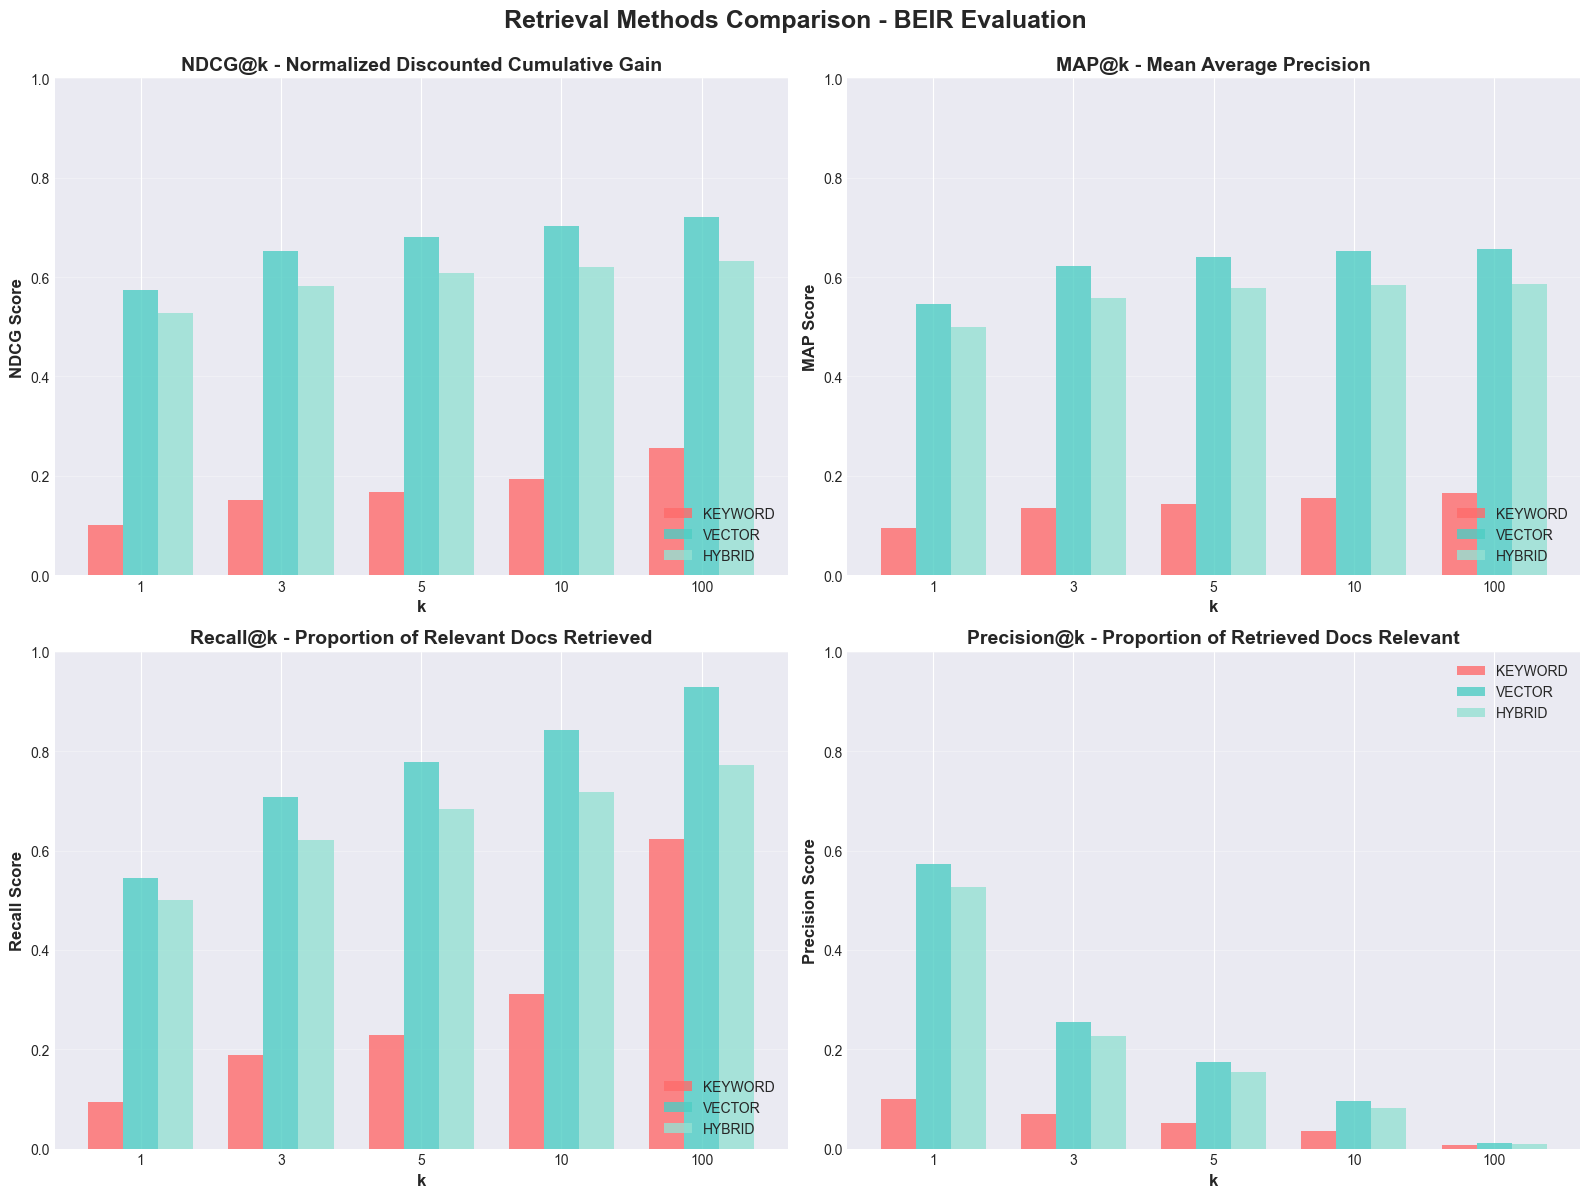

In [21]:
# Cell 10: Create comprehensive comparison charts
import matplotlib.pyplot as plt
import numpy as np

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {'keyword': '#FF6B6B', 'vector': '#4ECDC4', 'hybrid': '#95E1D3'}

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Retrieval Methods Comparison - BEIR Evaluation', fontsize=18, fontweight='bold', y=0.995)

k_values = [1, 3, 5, 10, 100]
x_pos = np.arange(len(k_values))
bar_width = 0.25

# ------------------------------------------------------------------
# Plot 1: NDCG Comparison
# ------------------------------------------------------------------
ax1 = axes[0, 0]
for i, method in enumerate(['keyword', 'vector', 'hybrid']):
    ndcg_values = [retrieval_results[method]['ndcg'].get(f"NDCG@{k}", 0) for k in k_values]
    ax1.bar(x_pos + i*bar_width, ndcg_values, bar_width, 
            label=method.upper(), color=colors[method], alpha=0.8)

ax1.set_xlabel('k', fontsize=12, fontweight='bold')
ax1.set_ylabel('NDCG Score', fontsize=12, fontweight='bold')
ax1.set_title('NDCG@k - Normalized Discounted Cumulative Gain', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos + bar_width)
ax1.set_xticklabels(k_values)
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# ------------------------------------------------------------------
# Plot 2: MAP Comparison
# ------------------------------------------------------------------
ax2 = axes[0, 1]
for i, method in enumerate(['keyword', 'vector', 'hybrid']):
    map_values = [retrieval_results[method]['map'].get(f"MAP@{k}", 0) for k in k_values]
    ax2.bar(x_pos + i*bar_width, map_values, bar_width, 
            label=method.upper(), color=colors[method], alpha=0.8)

ax2.set_xlabel('k', fontsize=12, fontweight='bold')
ax2.set_ylabel('MAP Score', fontsize=12, fontweight='bold')
ax2.set_title('MAP@k - Mean Average Precision', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos + bar_width)
ax2.set_xticklabels(k_values)
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

# ------------------------------------------------------------------
# Plot 3: Recall Comparison
# ------------------------------------------------------------------
ax3 = axes[1, 0]
for i, method in enumerate(['keyword', 'vector', 'hybrid']):
    recall_values = [retrieval_results[method]['recall'].get(f"Recall@{k}", 0) for k in k_values]
    ax3.bar(x_pos + i*bar_width, recall_values, bar_width, 
            label=method.upper(), color=colors[method], alpha=0.8)

ax3.set_xlabel('k', fontsize=12, fontweight='bold')
ax3.set_ylabel('Recall Score', fontsize=12, fontweight='bold')
ax3.set_title('Recall@k - Proportion of Relevant Docs Retrieved', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos + bar_width)
ax3.set_xticklabels(k_values)
ax3.legend(loc='lower right')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# ------------------------------------------------------------------
# Plot 4: Precision Comparison
# ------------------------------------------------------------------
ax4 = axes[1, 1]
for i, method in enumerate(['keyword', 'vector', 'hybrid']):
    precision_values = [retrieval_results[method]['precision'].get(f"P@{k}", 0) for k in k_values]
    ax4.bar(x_pos + i*bar_width, precision_values, bar_width, 
            label=method.upper(), color=colors[method], alpha=0.8)

ax4.set_xlabel('k', fontsize=12, fontweight='bold')
ax4.set_ylabel('Precision Score', fontsize=12, fontweight='bold')
ax4.set_title('Precision@k - Proportion of Retrieved Docs Relevant', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos + bar_width)
ax4.set_xticklabels(k_values)
ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()


 RETRIEVAL METHODS SUMMARY & WINNER ANALYSIS

 Average Performance Across All k Values:
--------------------------------------------------------------------------------
 Method  Avg NDCG  Avg MAP  Avg Recall  Avg Precision  Overall Score
KEYWORD    0.1740   0.1386      0.2897         0.0526         0.1637
 VECTOR    0.6661   0.6232      0.7608         0.2216         0.5679
 HYBRID    0.5942   0.5611      0.6590         0.1996         0.5035

 Winners by Metric:
--------------------------------------------------------------------------------
Avg NDCG            : VECTOR     (Score: 0.6661)
Avg MAP             : VECTOR     (Score: 0.6232)
Avg Recall          : VECTOR     (Score: 0.7608)
Avg Precision       : VECTOR     (Score: 0.2216)
Overall Score       : VECTOR     (Score: 0.5679)



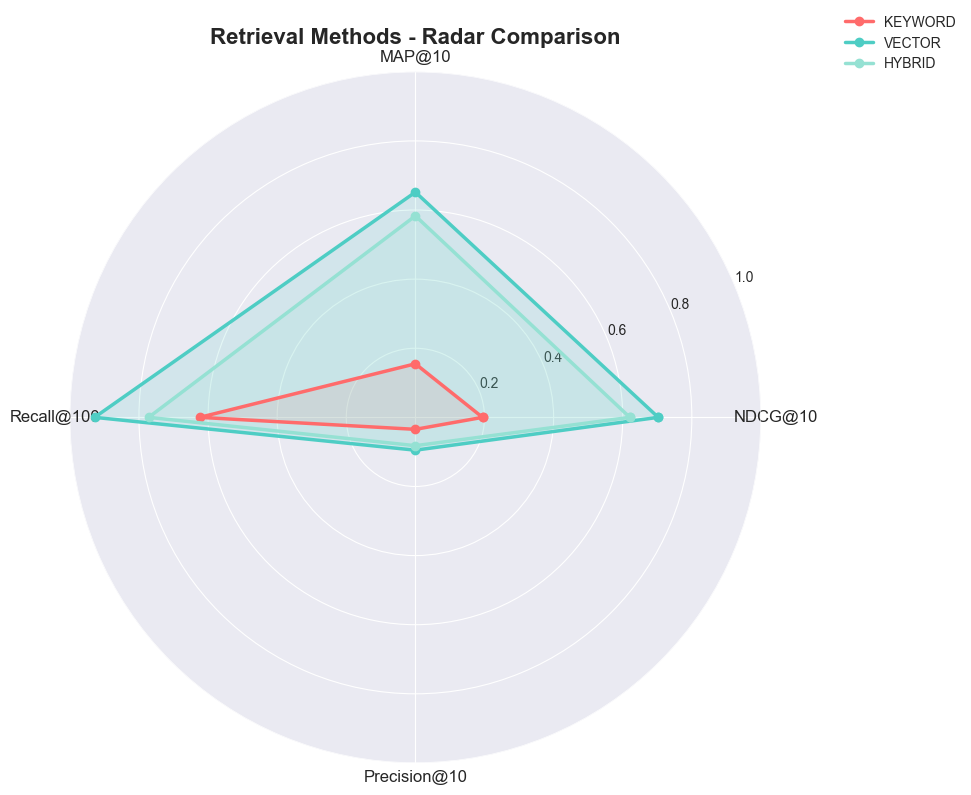


 Phase 1 Evaluation Complete - All metrics stored in 'retrieval_results' variable


In [22]:
print("\n" + "="*80)
print(" RETRIEVAL METHODS SUMMARY & WINNER ANALYSIS")
print("="*80)

# Calculate average scores across all k values
summary_data = []

for method in ['keyword', 'vector', 'hybrid']:
    avg_ndcg = np.mean([retrieval_results[method]['ndcg'].get(f"NDCG@{k}", 0) for k in k_values])
    avg_map = np.mean([retrieval_results[method]['map'].get(f"MAP@{k}", 0) for k in k_values])
    avg_recall = np.mean([retrieval_results[method]['recall'].get(f"Recall@{k}", 0) for k in k_values])
    avg_precision = np.mean([retrieval_results[method]['precision'].get(f"P@{k}", 0) for k in k_values])
    
    summary_data.append({
        'Method': method.upper(),
        'Avg NDCG': avg_ndcg,
        'Avg MAP': avg_map,
        'Avg Recall': avg_recall,
        'Avg Precision': avg_precision,
        'Overall Score': (avg_ndcg + avg_map + avg_recall + avg_precision) / 4
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("\n Average Performance Across All k Values:")
print("-" * 80)
print(summary_df.to_string(index=False))

# Determine winners for each metric
print("\n Winners by Metric:")
print("-" * 80)
for metric in ['Avg NDCG', 'Avg MAP', 'Avg Recall', 'Avg Precision', 'Overall Score']:
    winner_idx = summary_df[metric].idxmax()
    winner = summary_df.loc[winner_idx, 'Method']
    score = summary_df.loc[winner_idx, metric]
    print(f"{metric:20s}: {winner:10s} (Score: {score:.4f})")

print("\n" + "="*80)

# Create a radar chart for overall comparison
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['NDCG@10', 'MAP@10', 'Recall@100', 'Precision@10']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for method in ['keyword', 'vector', 'hybrid']:
    values = [
        retrieval_results[method]['ndcg'].get('NDCG@10', 0),
        retrieval_results[method]['map'].get('MAP@10', 0),
        retrieval_results[method]['recall'].get('Recall@100', 0),
        retrieval_results[method]['precision'].get('P@10', 0)
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2.5, label=method.upper(), color=colors[method])
    ax.fill(angles, values, alpha=0.15, color=colors[method])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_title('Retrieval Methods - Radar Comparison', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

print("\n Phase 1 Evaluation Complete - All metrics stored in 'retrieval_results' variable")

# Part 2: Evaluating RAG Pipelines

In [23]:
! pip install -qU "galileo[openai]"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
import getpass
import os

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

In [25]:
set_env_securely("GALILEO_API_KEY", "Enter your Galileo API key: ")

In [26]:
set_env_securely("OPENAI_API_KEY", "Enter your OpenAI API key: ")

In [27]:
import os
from galileo.openai import openai

# Initialize the Galileo wrapped OpenAI client
openai_client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [28]:
from galileo import log

def hybrid_search_beir_corpus(conn, embedding_model, search_phrase: str, top_k: int = 10, show_explain: bool = False):
    """
    Hybrid search on the beir_corpus table
    Combines keyword filtering with vector similarity search.
    
    Returns:
        tuple: (rows, columns, exec_plan_text)
        
    NOTE: This function is decorated with @log to capture retrieval metrics in Galileo
    """
    # Generate query embedding
    query_embedding = embedding_model.encode(
        [f"search_query: {search_phrase}"],
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False
    )[0].astype(np.float32).tolist()
    
    query_embedding_array = array.array('f', query_embedding)
    
    # Extract keywords for filtering (4+ letter words)
    words = re.findall(r'\b[a-zA-Z]{4,}\b', search_phrase.lower())
    
    # Build keyword filter conditions
    if words:
        search_words = words[:3]  # Use top 3 words
        or_conditions = []
        
        for i, word in enumerate(search_words):
            or_conditions.append(f"(LOWER(title) LIKE '%{word}%' OR LOWER(text) LIKE '%{word}%')")
        
        where_clause = " OR ".join(or_conditions)
    else:
        # No keywords, search everything
        where_clause = "1=1"
    
    # Hybrid search SQL
    sql = f"""
        SELECT {"/*+ GATHER_PLAN_STATISTICS */" if show_explain else ""}
            doc_id,
            title,
            SUBSTR(text, 1, 500) AS text_snippet,
            ROUND(1.0 - VECTOR_DISTANCE(embedding, :q, COSINE), 4) AS similarity_score
        FROM beir_corpus
        WHERE {where_clause}
        ORDER BY VECTOR_DISTANCE(embedding, :q, COSINE)
        FETCH APPROX FIRST {top_k} ROWS ONLY WITH TARGET ACCURACY 90
    """
    
    with conn.cursor() as cur:
        cur.execute(sql, q=query_embedding_array)
        rows = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        
        # Get execution plan if requested
        exec_plan_text = None
        if show_explain:
            cur.execute("SELECT PLAN_TABLE_OUTPUT FROM TABLE(DBMS_XPLAN.DISPLAY_CURSOR(FORMAT => 'TYPICAL'))")
            exec_plan_text = "\n".join([row[0] for row in cur.fetchall() if row[0]])
    
    # Format output for Galileo retriever span (return list of documents)
    @log(span_type="retriever", name="Hybrid Search - BEIR Corpus")
    def get_retrieved_docs(rows):
        retrieved_docs = []
        for row in rows:
            row_data = dict(zip(columns, row))
            retrieved_docs.append({
                "doc_id": row_data.get("DOC_ID"),
                "title": row_data.get("TITLE"),
                "snippet": row_data.get("TEXT_SNIPPET"),
                "score": float(row_data.get("SIMILARITY_SCORE", 0))
            })
        return retrieved_docs


    retrieved_docs = get_retrieved_docs(rows)
    
    return rows, columns, exec_plan_text, retrieved_docs


print(" Hybrid search function for beir_corpus table created!")

 Hybrid search function for beir_corpus table created!


In [29]:
@log(span_type="workflow", name="Research Paper RAG Pipeline")
def research_paper_assistant_rag_pipeline(
    conn,
    embedding_model,
    user_query: str,
    top_k: int = 10,
    retrieval_mode: str = "hybrid",
    show_explain: bool = False
):
    """
    Research Paper Assistant — Retrieval-Augmented Generation (RAG) pipeline
    built on SQL-based retrieval functions and powered by the OpenAI Responses API.

    Retrieval techniques available:
        - 'keyword'  → uses keyword_search_research_papers()
        - 'vector'   → uses vector_search_research_papers()
        - 'hybrid'   → uses hybrid_search_research_papers() [default]

    Args:
        conn: Oracle database connection.
        embedding_model: Embedding model (e.g., SentenceTransformer, Voyage).
        user_query (str): Research question from the user.
        top_k (int): Number of top documents to retrieve.
        retrieval_mode (str): Retrieval method ('keyword', 'vector', 'hybrid').
        show_explain (bool): Whether to show the SQL execution plan.

    Returns:
        str: LLM-generated research synthesis with citations.
        
    NOTE: This function is decorated with @log to create a workflow span containing
          the retrieval span (from hybrid_search_beir_corpus) and LLM span (from OpenAI).
    """

    # ----------------------------------------------------------------------
    # 1. Retrieve relevant research papers using the selected retrieval mode
    # ----------------------------------------------------------------------
    if retrieval_mode == "keyword":
        rows, columns, exec_plan_text, retrieved_docs = vector_search_beir_corpus(conn, user_query)

    elif retrieval_mode == "vector":
        rows, columns, exec_plan_text, retrieved_docs = hybrid_search_beir_corpus(conn, embedding_model, user_query, top_k)

    else:  # default: hybrid retrieval
        rows, columns, exec_plan_text, retrieved_docs = hybrid_search_beir_corpus(
            conn=conn,
            embedding_model=embedding_model,
            search_phrase=user_query,
            top_k=top_k,
            show_explain=show_explain
        )

    retrieved_count = len(rows) if rows else 0
    print(f" Retrieved {retrieved_count} papers using {retrieval_mode.upper()} retrieval.")


    # ----------------------------------------------------------------------
    # 2. Convert retrieved rows to formatted LLM context
    # ----------------------------------------------------------------------
    formatted_context = ""
    if retrieved_count > 0:
        formatted_context += f"\n\n📚 {retrieved_count} relevant research papers retrieved:\n\n"
        for i, row in enumerate(rows):
            row_data = dict(zip(columns, row))
            title = row_data.get("TITLE", "Untitled Paper")
            abstract = row_data.get("ABSTRACT", "No abstract available.")
            snippet = row_data.get("TEXT_SNIPPET", "")
            score = (
                row_data.get("SIMILARITY_SCORE")
                or row_data.get("TEXT_RELEVANCE_SCORE")
                or "N/A"
            )
            formatted_context += (
                f"[{i+1}] **{title}**\n"
                f"Abstract: {abstract}\n"
                f"Snippet: {snippet}\n"
                f"Relevance Score: {score}\n\n"
            )
    else:
        formatted_context = "\n\n⚠️ No relevant papers were retrieved from the database.\n"

    # ----------------------------------------------------------------------
    # 3. Construct the prompt for the Responses API
    # ----------------------------------------------------------------------
    prompt = f"""
            You are a **Research Paper Assistant** that synthesizes academic literature to help answer user questions.

            User Query: {user_query}

            Number of retrieved papers: {retrieved_count}
            {formatted_context}

            Please:
            - Summarize the findings most relevant to the query.
            - Use citation numbers [X] to support claims.
            - Highlight consensus, innovation, or research gaps.
            - If there is insufficient context, clearly say so.
            """

    # ----------------------------------------------------------------------
    # 4. Call the OpenAI Responses API
    # ----------------------------------------------------------------------
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a scientific research assistant. Use only the provided context to answer. Always cite papers [1], [2], etc."},
            {"role": "user", "content": prompt}
        ]
    )

    # ----------------------------------------------------------------------
    # 5. Optionally print SQL execution plan (if hybrid)
    # ----------------------------------------------------------------------
    if show_explain and exec_plan_text:
        print("\n====== SQL Execution Plan ======")
        print(exec_plan_text)
        print("================================\n")

    # ----------------------------------------------------------------------
    # 6. Return the LLM’s output text
    # ----------------------------------------------------------------------
    return response.choices[0].message.content


In [30]:
from galileo import galileo_context

galileo_context.init(
    project="ai_system_evaluation_project",
    log_stream="ai_system_evaluation_showcase"
)

summary = research_paper_assistant_rag_pipeline(
    conn=conn,
    embedding_model=embedding_model,
    user_query="Can you get me some information on the research in the field of AI?",
    top_k=5,
    retrieval_mode="hybrid",
    show_explain=False
)

# Flush the logger to ensure all traces are uploaded to Galileo
# Note: The @log decorator automatically flushes when the decorated function exits,
# but in notebooks it's good practice to explicitly flush to ensure data is sent
galileo_context.flush()
print(" RAG pipeline traces flushed to Galileo")

2026-02-12 11:59:05 - HTTP Request: GET https://api.galileo.ai/healthcheck "HTTP/1.1 200 OK"
2026-02-12 11:59:06 - HTTP Request: POST https://api.galileo.ai/login/api_key "HTTP/1.1 200 OK"
2026-02-12 11:59:06 - HTTP Request: GET https://api.galileo.ai/current_user "HTTP/1.1 200 OK"
2026-02-12 11:59:06 - HTTP Request: GET https://api.galileo.ai/projects?project_name=ai_system_evaluation_project&type=gen_ai "HTTP/1.1 200 OK"
2026-02-12 11:59:07 - HTTP Request: GET https://api.galileo.ai/projects/3bea3997-d6ea-4b22-a94b-f0000bd1c3f7/log_streams?include_counts=false "HTTP/1.1 200 OK"
 Retrieved 5 papers using HYBRID retrieval.
2026-02-12 11:59:20 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-12 11:59:21 - HTTP Request: POST https://api.galileo.ai/v2/projects/3bea3997-d6ea-4b22-a94b-f0000bd1c3f7/traces "HTTP/1.1 200 OK"
 RAG pipeline traces flushed to Galileo


In [31]:
print(summary)

The query regarding research in the field of AI did not retrieve directly relevant papers; however, the available papers can still provide some contextual information about related research fields.

1. **Cognition and Expertise in Sports**: A study reviewed whether extensive sports training, involving both fitness and cognitive elements, enhances cognitive processes as measured in laboratory settings [1]. While this does not directly address AI, it implicates the potential overlaps in AI and human cognitive research, suggesting areas where AI could possibly be employed to simulate or enhance cognitive training.

2. **Public Health Workforce Development**: This research aims to develop a multidisciplinary framework for the public health workforce, emphasizing systemic support. Although not AI-focused, such interdisciplinary approaches could benefit from AI tools for modeling and optimizing public health systems [2].

3. **Cardiovascular Care Research**: This paper advocates for evidence